# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle MARTY, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [4]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

from functions.modelling import *

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [5]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

from functions.importing import read_whole_pandas_df

print(f"✅ read_whole_pandas_df function imported; alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function imported; alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Velo'v data import

In [6]:
# Data folder's path
BASE_PATH = r"data/"
# Velo'v data's path
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
# Velo'v stations locations file's path
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
# Lyon's contours dataset's path
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
# Coordinates of the center of Lyon
LYON_CENTER = (45.764043, 4.835659)
# Importing the data into a dataframe
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=True)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00


#### d/ Weather data import
##### 1) CSV import
> "Données climatologiques de base - quotidiennes" Meteo-France.
> https://meteo.data.gouv.fr/datasets/6569b51ae64326786e4e8e1a

In [7]:
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv"

from functions.importing import read_meteo_data

print(f"✅ read_meteo_data function imported with path:\n{METEO_PATH}")

df_meteo = read_meteo_data(METEO_PATH)
print("✅ The weather dataset was successfully imported")

display(df_meteo.head(5))
df_meteo.shape

✅ read_meteo_data function imported with path:
data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
Lecture du fichier météo : data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
✅ The weather dataset was successfully imported


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630301,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630302,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630303,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630304,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630305,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1245508, 58)

In this dataset, we have acces to several informations related to the weather conditions. In our model, we will focus on the effect of the wind, the temperature and precipitation. According to the "weather code", the columns below are: 
- RR : precipitation (mm) 
- TN,TX ,TM  : minimal temperature, maximum temperature, mean temparture 
- FF : wind

###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [8]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\Alix\AppData\Local\Temp\ipykernel_22472\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00


#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [9]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0


###  <u> **2 - Adding the `distance` column** </u>

In [10]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271301,2101.306115,1728.531155,2359.789599,1897.619990,2771.548411,1581.022503,1739.714329,...,1487.311727,2209.079367,8316.839400,7914.027093,1190.596433,1448.733485,1397.488839,1707.214746,4936.861621,5241.842046
10063,3672.322221,0.000000,367.937601,1918.014222,5276.485492,2393.483029,3362.975962,2193.760999,4699.773041,5159.729411,...,2185.076724,2763.907648,6395.079493,4458.602747,4860.315824,2233.220170,4667.580451,2109.599779,1478.056510,2520.604551
10021,4038.271301,367.937601,0.000000,2269.206815,5644.183932,2665.024201,3700.574285,2477.416757,5062.122623,5525.999425,...,2550.967781,3042.980467,6250.871362,4115.750370,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306115,1918.014222,2269.206815,0.000000,3484.503141,2327.918947,1467.055847,883.373258,2817.475111,3322.282657,...,940.820395,2518.623358,7840.242909,6376.168575,3252.453650,1066.873708,2814.886550,1368.271058,3379.142600,4169.994273
7045,1728.531155,5276.485492,5644.183932,3484.503141,0.000000,4061.439765,2522.986998,3875.840707,919.283986,340.362043,...,3133.747731,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331063


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0,4659.845582
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1629.727220
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1610.518885
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0,3446.325685
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0,807.072642


###  <u> **3 - Filtering** </u>
#### i/ Filtering the Velo'v data based on speed

In [11]:
# Creating a `speed` column based on the travel time and the distance (values in km/h for future readability)
df_lyon["speed"] = (df_lyon["distance"]/1000) / (df_lyon["travel_time"]/60)
# Filtering the data where the speed is below 10 km/h or above 30 km/h
df_lyon = df_lyon[df_lyon.speed.between(3,40)]
# Filtering the travels where the exit station and the return station are identical
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

print("There are ", df_lyon.shape[0], "travels after filtering.")
df_lyon.sample(10)

There are  1930574 travels after filtering.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed
476939,7053,7053 - JAURÈS / THIBAUDIÈRE,2019-04-19 08:54:00+02:00,3011.0,3011 - PART-DIEU / CUIRASSIERS,2019-04-19 09:01:00+02:00,2019-04-19 08:00:00+02:00,4,4,7.0,1439.926672,12.342229
356288,10074,10074 - ZOLA / PASSAGE REY,2019-04-13 22:21:00+02:00,10083.0,10083 - CHATEAU GAILLARD / BIENVENUS,2019-04-13 22:27:00+02:00,2019-04-13 22:00:00+02:00,5,4,6.0,1043.342286,10.433423
1561687,3004,3004 - BOURSE DU TRAVAIL,2019-06-03 17:16:00+02:00,7003.0,7003 - GAMBETTA / GARIBALDI,2019-06-03 17:23:00+02:00,2019-06-03 17:00:00+02:00,0,6,7.0,935.331663,8.017129
984562,3086,3086 - FEUILLAT / LACASSAGNE,2019-05-11 14:26:00+02:00,8030.0,8030 - LAËNNEC,2019-05-11 14:29:00+02:00,2019-05-11 14:00:00+02:00,5,5,3.0,958.581239,19.171625
751678,3044,3044 - QUAI AUGAGNEUR,2019-05-01 18:17:00+02:00,10021.0,10021 - GRANDCLÉMENT,2019-05-01 18:43:00+02:00,2019-05-01 18:00:00+02:00,2,5,26.0,3808.639282,8.789168
1039481,5001,5001 - PLACE VARILLON (FUNICULAIRE ST JUST),2019-05-14 08:30:00+02:00,2009.0,2009 - CONFLUENCE / DOCKS,2019-05-14 08:44:00+02:00,2019-05-14 08:00:00+02:00,1,5,14.0,1962.579469,8.411055
1455419,2042,2042 - JOFFRE / VAUBECOUR,2019-05-29 20:20:00+02:00,3016.0,3016 - LIBERTÉ / PART-DIEU,2019-05-29 20:29:00+02:00,2019-05-29 20:00:00+02:00,2,5,9.0,1591.678411,10.611189
1518695,2035,2035 - CHILDEBERT / RIVIÈRE,2019-06-01 16:49:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-06-01 16:56:00+02:00,2019-06-01 16:00:00+02:00,5,6,7.0,1087.912443,9.324964
566796,1002,1002 - OPÉRA,2019-04-23 16:16:00+02:00,2014.0,2014 - JACOBINS,2019-04-23 16:24:00+02:00,2019-04-23 16:00:00+02:00,1,4,8.0,783.368762,5.875266
690023,8040,8040 - AMBROISE PARÉ,2019-04-29 19:02:00+02:00,7004.0,7004 - MAIRIE DU 7E,2019-04-29 19:24:00+02:00,2019-04-29 19:00:00+02:00,0,4,22.0,3410.471029,9.301285


Average speed of the filtered data:  9.7 km/h
Average time for a 15km travel:  93 minutes


c:\Users\Alix\anaconda3\envs\dspap-basic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


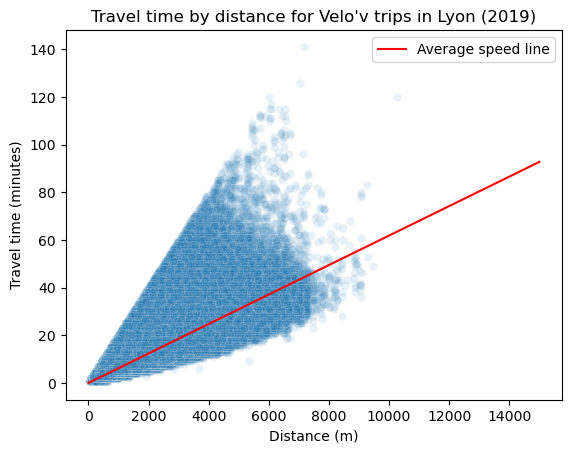

In [12]:
# Displaying a scatter graph of the travel time by the distance
sns.scatterplot(data=df_lyon, x="distance", y="travel_time", alpha=0.1)
plt.title("Travel time by distance for Velo'v trips in Lyon (2019)")
plt.xlabel("Distance (m)")
plt.ylabel("Travel time (minutes)")
# Adding the average speed line computed from the filtered data
avg_speed = df_lyon["speed"].sum() / (df_lyon["speed"].count())  # in km/h
print("Average speed of the filtered data: ", round(avg_speed,2), "km/h")
print("Average time for a 15km travel: ", round(60*15/avg_speed), "minutes")
plt.plot([0, 15000], [0, 60*15/(avg_speed)], color='red', label='Average speed line')
plt.legend()
plt.show()

#### ii/ Time filtering the weather data
We will merge the weather dataset with the  velo-lyon dataset. We have to work on the same period, so we clean our weather dataset. The period selected is between the 01/01/2019 and the 22/04/2021

In [13]:
# Date conversion
df_meteo['date'] = pd.to_datetime(df_meteo['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Filter data between 2019-01-01 and 2021-04-22
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2021-04-22")

df_meteo = df_meteo[(df_meteo['date'] >= start_date) & (df_meteo['date'] <= end_date)]
df_meteo.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
23102,69007001,AMPUIS,45.490667,4.811167,157,20190101,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01
23103,69007001,AMPUIS,45.490667,4.811167,157,20190102,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-02
23104,69007001,AMPUIS,45.490667,4.811167,157,20190103,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-03
23105,69007001,AMPUIS,45.490667,4.811167,157,20190104,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-04
23106,69007001,AMPUIS,45.490667,4.811167,157,20190105,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-05


In [14]:
#Convert AAAAMMJJ to datetime
df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify the conversion
print(df_meteo[["AAAAMMJJ", "datetime_day"]].head())

       AAAAMMJJ datetime_day
23102  20190101   2019-01-01
23103  20190102   2019-01-02
23104  20190103   2019-01-03
23105  20190104   2019-01-04
23106  20190105   2019-01-05


#### iii/ Filtering the weather data to 1 station

In [15]:
df_meteo.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date',
       'datetime_day'],
      dtype='object')

In [16]:
df_meteo['NOM_USUEL'].unique()


array(['AMPUIS', 'ANCY_SAPC', 'LE BREUIL', 'BRINDAS', 'LYON-BRON',
       'CALUIRE4', 'CERCIE EN BEAUJOLAIS', 'CONDRIEU',
       'COURS LA VILLE_SAPC', 'LES HAIES', 'JULLIE', 'LAMURE-SUR-AZER',
       'LANCIE', 'LIERGUES_SAPC', "LYON TETE D'OR", 'LYON-FOURVIERE',
       'MONSOLS', 'MONTROTTIER', 'MORNANT', 'POMMIERS', 'PONT TRAMBOUZE',
       'AZOLETTE', 'LES SAUVAGES', 'ST-CYR-CHATOUX', 'ST-DIDIER-RIVER',
       'ST-DIDIER-BEAUJ', "ST-GENIS-L'ARGENTIERE", 'ST-GENIS-LAVAL',
       'ST-GEORGES-REN', 'ST-GERMAIN-L AR', 'POPEY', 'ST-SYMPHORIEN-C',
       'SAINT-VERAND', 'TRADES', 'VAUX-EN-BEAUJOL', 'VAUXRENARD',
       'VILLEFRANCHE', 'CORBAS', 'RILLIEUX', 'LYON-ST EXUPERY'],
      dtype=object)

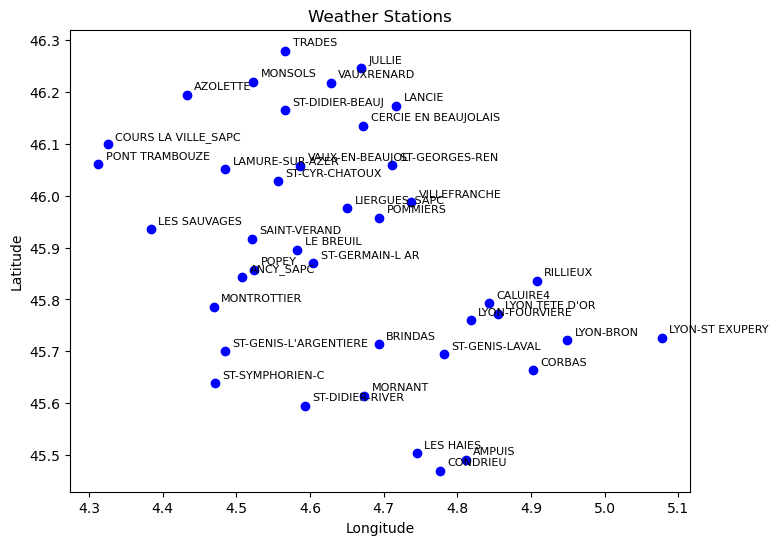

In [17]:
# Supprimer les doublons pour ne garder qu'une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

plt.figure(figsize=(8,6))
plt.scatter(stations['LON'], stations['LAT'], color='blue')

# Ajouter les noms des stations
for i, row in stations.iterrows():
    plt.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['NOM_USUEL'], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations")
plt.show()



In [18]:
# Exemple : coordonnées du centre de Lyon
lyon_center = (45.75, 4.85)

# Supprimer doublons pour garder une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

# Fonction Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon Terre en km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Calculer la distance de chaque station au centre de Lyon
stations['distance_lyon_km'] = stations.apply(
    lambda row: haversine(row['LAT'], row['LON'], lyon_center[0], lyon_center[1]),
    axis=1
)

# Trier par distance
stations = stations.sort_values('distance_lyon_km')

# Afficher les 5 stations les plus proches
print(stations[['NOM_USUEL','LAT','LON','distance_lyon_km']].head())


             NOM_USUEL        LAT       LON  distance_lyon_km
470489  LYON TETE D'OR  45.772833  4.855167          2.570359
507643  LYON-FOURVIERE  45.759667  4.818167          2.693517
179616        CALUIRE4  45.792833  4.843500          4.789420
817072  ST-GENIS-LAVAL  45.694667  4.782333          8.090095
109675       LYON-BRON  45.721333  4.949167          8.330414


In [19]:
# Liste des colonnes vent
vent_cols = ['FFM','FF2M','FXI','FXI2','FXI3S',"RR"]

# Vérifier par station
vent_dispo = df_meteo.groupby('NOM_USUEL')[vent_cols].apply(lambda x: x.notna().sum())

# Afficher les stations et le nombre de valeurs disponibles
print(vent_dispo.sort_values(by='FFM', ascending=False))


                       FFM  FF2M  FXI  FXI2  FXI3S   RR
NOM_USUEL                                              
ST-GEORGES-REN         843     0  843     0    843  843
LYON-ST EXUPERY        843     0  842     0    842  843
LYON-BRON              842     0  841     0    841  843
VAUXRENARD             838     0  838     0    838  843
LES SAUVAGES           818     0  821     0    822  843
BRINDAS                817     0  818     0    818  843
ANCY_SAPC                0     0    0     0      0  843
AMPUIS                   0     0    0     0      0  700
CORBAS                   0     0    0     0      0  365
CONDRIEU                 0     0    0     0      0  731
CERCIE EN BEAUJOLAIS     0     0    0     0      0  731
CALUIRE4                 0     0    0     0      0  700
AZOLETTE                 0     0    0     0      0  304
LE BREUIL                0     0    0     0      0  843
LANCIE                   0     0    0     0      0  700
COURS LA VILLE_SAPC      0     0    0     0     

We keep the meteo information of the station Lyon - Bron because it is the closest station from the center of Lyon that measures, the temperature the wind and the precipitation. 

In [20]:
# Filter on the station "LYON-BRON"
meteo_bron = df_meteo[df_meteo['NOM_USUEL'] == "LYON-BRON"].copy()

# Verify the result 
print(meteo_bron[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates())
print(meteo_bron.head())


        NOM_USUEL        LAT       LON
109675  LYON-BRON  45.721333  4.949167
        NUM_POSTE  NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
109675   69029001  LYON-BRON  45.721333  4.949167   202  20190101  0.0  1.0   
109676   69029001  LYON-BRON  45.721333  4.949167   202  20190102  0.0  1.0   
109677   69029001  LYON-BRON  45.721333  4.949167   202  20190103  0.0  1.0   
109678   69029001  LYON-BRON  45.721333  4.949167   202  20190104  0.0  1.0   
109679   69029001  LYON-BRON  45.721333  4.949167   202  20190105  0.0  1.0   

         TN  QTN  ...  FXI3S  QFXI3S  DXI3S  QDXI3S   HXI3S  QHXI3S  DRR  \
109675  6.5  1.0  ...    8.6     1.0   10.0     1.0  1738.0     9.0  0.0   
109676  4.0  1.0  ...   14.3     1.0  350.0     1.0  1410.0     9.0  0.0   
109677 -0.1  1.0  ...   12.6     1.0  360.0     1.0  1425.0     9.0  0.0   
109678 -0.2  1.0  ...   10.6     1.0  350.0     1.0  1319.0     9.0  0.0   
109679  1.2  1.0  ...   10.9     1.0  320.0     1.0   117.0     9.0

###  <u> **4 - Converting the weather data into usable data for modelling** </u>


In [21]:
# Créer la température moyenne si TM non fiable
meteo_bron['T_moy'] = meteo_bron[['TN','TX']].mean(axis=1)

# Convertir le vent (rafale max 3s FXI3S) en km/h
meteo_bron['vent_kmh'] = meteo_bron['FFM'] * 3.6

# Créer un DataFrame journalier moyen
meteo_jour = meteo_bron.groupby('AAAAMMJJ').agg({
    'T_moy': 'mean',        # Température moyenne
    'RR': 'sum',            # Total précipitations par jour
    'vent_kmh': 'mean'      # Vent moyen par jour
}).reset_index()

# Afficher les premières lignes
display(meteo_jour.head())
meteo_jour.shape


,AAAAMMJJ,T_moy,RR,vent_kmh
0,20190101,6.90,0.0,13.32
1,20190102,5.45,0.0,21.96
2,20190103,2.45,0.0,20.52
3,20190104,2.75,0.0,18.00
4,20190105,2.75,0.0,19.08


(843, 4)

In [22]:
#We create the temperature categories

conditions_temp = [
    (meteo_jour["T_moy"] < 0), 
    (meteo_jour["T_moy"] >= 0) & (meteo_jour["T_moy"] < 10),
    (meteo_jour["T_moy"] >= 10) & (meteo_jour["T_moy"] < 20),
    (meteo_jour["T_moy"] >= 20)
]
categories_temp = ["cold", "cool", "warm", "very_warm"]
meteo_jour["temp_category"] = np.select(conditions_temp, categories_temp, default="unknown")

#We create the rainfall categories

conditions_RR = [
    (meteo_jour["RR"] == 0),
    (meteo_jour["RR"] > 0) & (meteo_jour["RR"] <= 2),
    (meteo_jour["RR"] > 2) & (meteo_jour["RR"] <= 10),
    (meteo_jour["RR"] > 10)
]

categories_RR = ["none", "light", "moderate", "heavy"]

meteo_jour["rain_category"] = np.select(conditions_RR, categories_RR, default="none")

#We create the wind categories  

conditions_wind = [
    (meteo_jour["vent_kmh"] < 10),
    (meteo_jour["vent_kmh"] >= 10) & (meteo_jour["vent_kmh"] < 20),
    (meteo_jour["vent_kmh"] >= 20) & (meteo_jour["vent_kmh"] < 40),
    (meteo_jour["vent_kmh"] >= 40)
]   
categories_wind = ["calm", "light", "windy", "stormy"]
meteo_jour["wind_category"] = np.select(conditions_wind, categories_wind, default="unknown")

meteo_jour

,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category
0,20190101,6.90,0.0,13.32,cool,none,light
1,20190102,5.45,0.0,21.96,cool,none,windy
2,20190103,2.45,0.0,20.52,cool,none,windy
3,20190104,2.75,0.0,18.00,cool,none,light
4,20190105,2.75,0.0,19.08,cool,none,light
...,...,...,...,...,...,...,...
838,20210418,9.25,0.0,15.48,cool,none,light
839,20210419,10.25,0.0,10.44,warm,none,light
840,20210420,11.15,0.2,7.20,warm,light,calm
841,20210421,12.80,0.2,7.92,warm,light,calm


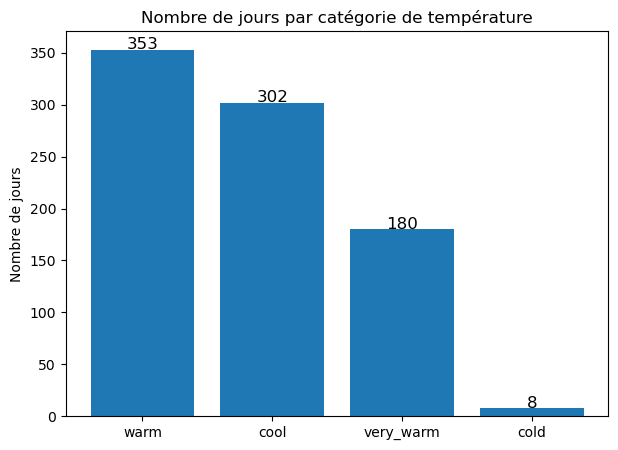

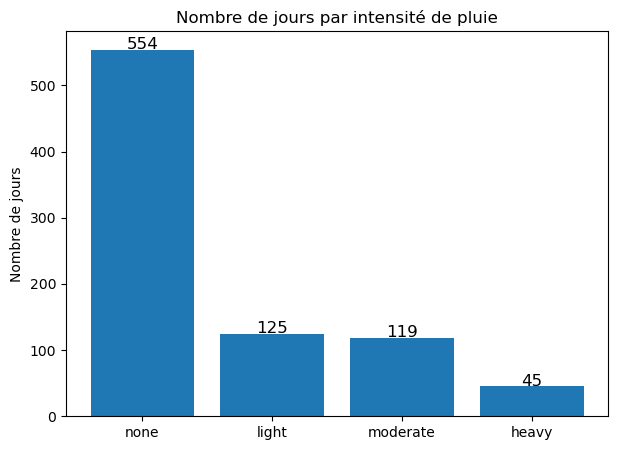

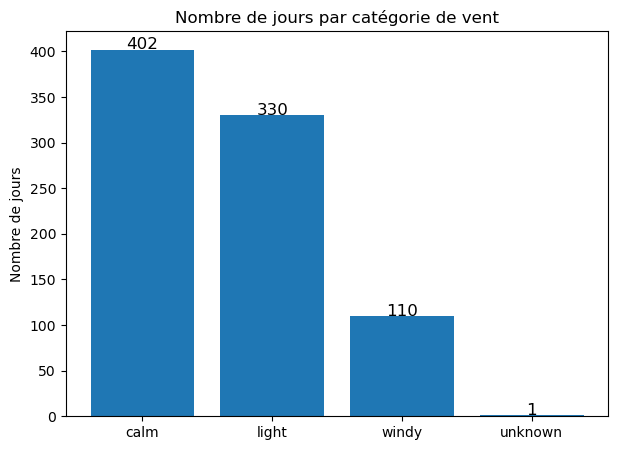

In [23]:
# Plot for temperature categories
plt.figure(figsize=(7,5))
temp_counts = meteo_jour["temp_category"].value_counts()

plt.bar(temp_counts.index, temp_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de température")

for i, v in enumerate(temp_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for rain categories
plt.figure(figsize=(7,5))
rain_counts = meteo_jour["rain_category"].value_counts()

plt.bar(rain_counts.index, rain_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par intensité de pluie")

for i, v in enumerate(rain_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for wind categories
plt.figure(figsize=(7,5))
wind_counts = meteo_jour["wind_category"].value_counts()

plt.bar(wind_counts.index, wind_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de vent")

for i, v in enumerate(wind_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()




Note : I don't know why there is an unkwon category 

In [24]:
# Convertir en string
meteo_jour["AAAAMMJJ"] = meteo_jour["AAAAMMJJ"].astype(int).astype(str)

# Transformer en datetime
meteo_jour["datetime_day"] = pd.to_datetime(meteo_jour["AAAAMMJJ"], format="%Y%m%d").dt.date

# Vérifier
print(meteo_jour)


     AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category  \
0    20190101   6.90  0.0     13.32          cool          none         light   
1    20190102   5.45  0.0     21.96          cool          none         windy   
2    20190103   2.45  0.0     20.52          cool          none         windy   
3    20190104   2.75  0.0     18.00          cool          none         light   
4    20190105   2.75  0.0     19.08          cool          none         light   
..        ...    ...  ...       ...           ...           ...           ...   
838  20210418   9.25  0.0     15.48          cool          none         light   
839  20210419  10.25  0.0     10.44          warm          none         light   
840  20210420  11.15  0.2      7.20          warm         light          calm   
841  20210421  12.80  0.2      7.92          warm         light          calm   
842  20210422  13.85  0.0      9.00          warm          none          calm   

    datetime_day  
0     20

In [25]:
df_lyon["datetime_day"] = pd.to_datetime(df_lyon["datetime_1h"], format="%Y%m%d").dt.date
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed,datetime_day
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0,4659.845582,9.985383,2019-04-01
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1629.727220,13.969090,2019-04-01
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1610.518885,13.804448,2019-04-01
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0,3446.325685,14.769967,2019-04-01
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0,807.072642,12.106090,2019-04-01


In [26]:
df_meteo = df_lyon.merge(meteo_jour, on="datetime_day", how="left")
df_meteo

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed,datetime_day,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0,4659.845582,9.985383,2019-04-01,20190401,13.35,0.0,3.96,warm,none,calm
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1629.727220,13.969090,2019-04-01,20190401,13.35,0.0,3.96,warm,none,calm
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1610.518885,13.804448,2019-04-01,20190401,13.35,0.0,3.96,warm,none,calm
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0,3446.325685,14.769967,2019-04-01,20190401,13.35,0.0,3.96,warm,none,calm
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0,807.072642,12.106090,2019-04-01,20190401,13.35,0.0,3.96,warm,none,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930569,7024,7024 - BANCEL / CHEVREUL,2019-06-30 23:59:00+02:00,2012.0,2012 - GAILLETON,2019-07-01 00:05:00+02:00,2019-06-30 23:00:00+02:00,6,6,6.0,780.698976,7.806990,2019-06-30,20190630,30.85,0.0,8.64,very_warm,none,calm
1930570,10087,10087 - BARATIN,2019-06-30 23:59:00+02:00,10074.0,10074 - ZOLA / PASSAGE REY,2019-07-01 00:23:00+02:00,2019-06-30 23:00:00+02:00,6,6,24.0,2143.386270,5.358466,2019-06-30,20190630,30.85,0.0,8.64,very_warm,none,calm
1930571,2026,2026 - RÉPUBLIQUE / PAUFIQUE,2019-06-30 23:59:00+02:00,10011.0,10011 - GRATTE-CIEL,2019-07-01 00:14:00+02:00,2019-06-30 23:00:00+02:00,6,6,15.0,3669.217483,14.676870,2019-06-30,20190630,30.85,0.0,8.64,very_warm,none,calm
1930572,3084,3084 - DESAIX,2019-06-30 23:59:00+02:00,7023.0,7023 - BERTHELOT / ROUTE DE VIENNE,2019-07-01 00:09:00+02:00,2019-06-30 23:00:00+02:00,6,6,10.0,1669.803364,10.018820,2019-06-30,20190630,30.85,0.0,8.64,very_warm,none,calm


## <u> **II/ Regression modelling** </u>
###  <u> **1 - Simple linear regression** </u>
#### a/ Model 0 definition

In [27]:
# STEP 1 - EXTRACTING THE RELEVANT COLUMNS
y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - SPLITTING THE DATA INTO TRAINING AND TEST SETS
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - CREATING AND TRAINING THE MODEL
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

# Displaying the intercept with minutes (rounded to the lower value) and seconds and the average speed of the biker in km/h
print("The model's intercept is: ", int(model.intercept_), "minutes and", int((model.intercept_%1)*60), "seconds")
print("The estimated biker goes at: ", int(360/(model.coef_[0]*60))/100, "km/h in average")

# STEP 4 - EVALUATING THE MODEL
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

The model's intercept is:  1 minutes and 19 seconds
The estimated biker goes at:  10.31 km/h in average


R²      0.658725
MSE    18.788255
MAE     2.751422
dtype: float64

#### b/ Model 0 estimation

In [28]:
estimated_time_15km = model.intercept_ + 15000*model.coef_[0]
print("Estimated time for a 5km travel on bike: ", round(estimated_time_15km), "minutes")

Estimated time for a 5km travel on bike:  89 minutes


In [29]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 5min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

###  <u> **1 - Multiple linear regression** </u>
#### a/ Model 1 - Adding the day of the week parameter

In [30]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day']].copy()
# Converting day to integer type
df_model1['day'] = df_model1['day'].astype(int)
df_model1.sample(5)

,distance,travel_time,datetime_1h,day
1116897,622.474943,6.0,2019-05-16 20:00:00+02:00,3
1802817,1118.611776,7.0,2019-06-14 20:00:00+02:00,4
20832,962.643995,8.0,2019-04-01 18:00:00+02:00,0
118310,1602.856832,11.0,2019-04-05 13:00:00+02:00,4
177063,2198.396294,12.0,2019-04-07 19:00:00+02:00,6


In [31]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies_day = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies_day.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6
1486566,1854.225506,10.0,2019-05-31 09:00:00+02:00,0,0,0,1,0,0
1993113,753.781446,5.0,2019-06-23 17:00:00+02:00,0,0,0,0,0,1
403816,725.914246,4.0,2019-04-16 11:00:00+02:00,1,0,0,0,0,0
734640,2987.843759,18.0,2019-05-01 11:00:00+02:00,0,1,0,0,0,0
1442705,2278.152927,12.0,2019-05-29 13:00:00+02:00,0,1,0,0,0,0


,Coefficient
day_5,1.280329
day_6,1.104139
day_2,0.372667
day_4,0.314074
day_3,0.122918
day_1,0.036479
distance,0.005801
intercept,0.971663


R²      0.661900
MSE    18.613482
MAE     2.748773
dtype: float64

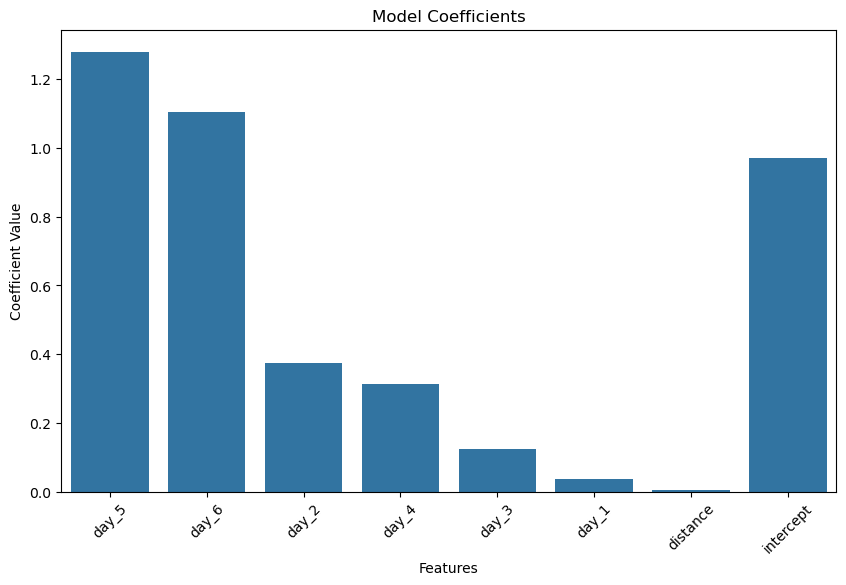

In [32]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies_day['travel_time']
X = df_model1_dummies_day.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Model 1 - Adding the time of day parameter

In [33]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
126582,1993.253285,9.0,2019-04-05 17:00:00+02:00,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1717877,1631.742955,8.0,2019-06-11 07:00:00+02:00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883367,3833.217036,17.0,2019-05-07 08:00:00+02:00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1133386,3314.404478,24.0,2019-05-17 13:00:00+02:00,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
923010,2149.620900,9.0,2019-05-09 07:00:00+02:00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Coefficient
day_5,1.081295
day_6,0.878439
hour_15,0.700195
hour_16,0.562581
hour_3,0.549247
hour_2,0.532429
hour_1,0.427049
hour_14,0.386314
day_2,0.354920
day_4,0.297086


R²      0.666599
MSE    18.354778
MAE     2.734687
dtype: float64

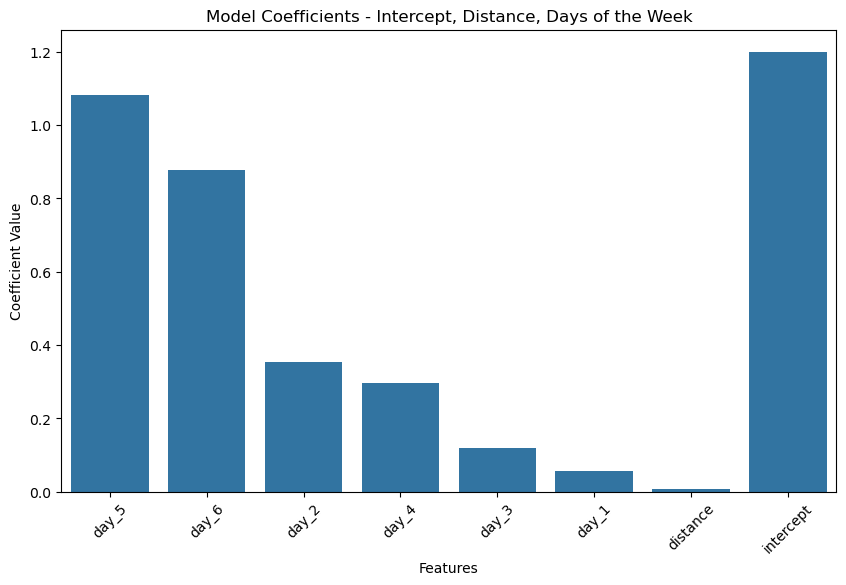

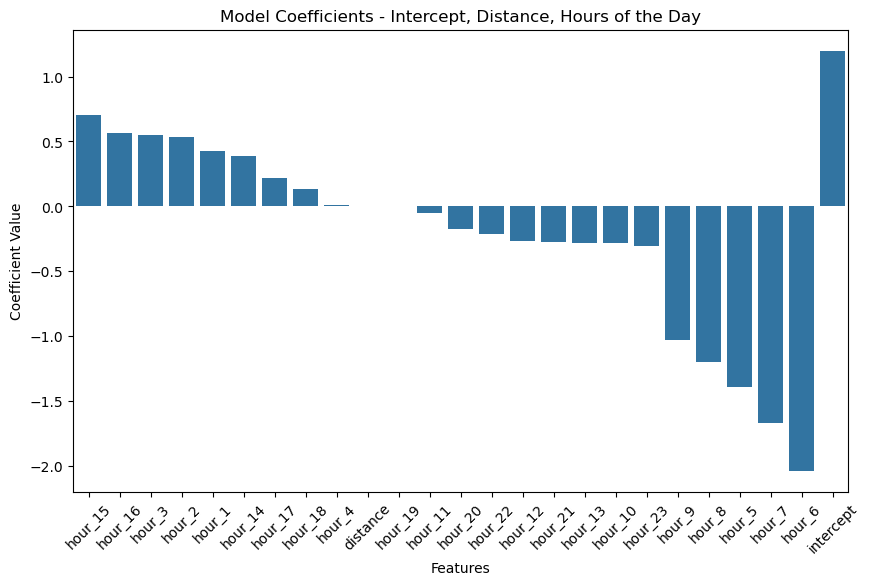

C:\Users\Alix\AppData\Local\Temp\ipykernel_22472\1607004228.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


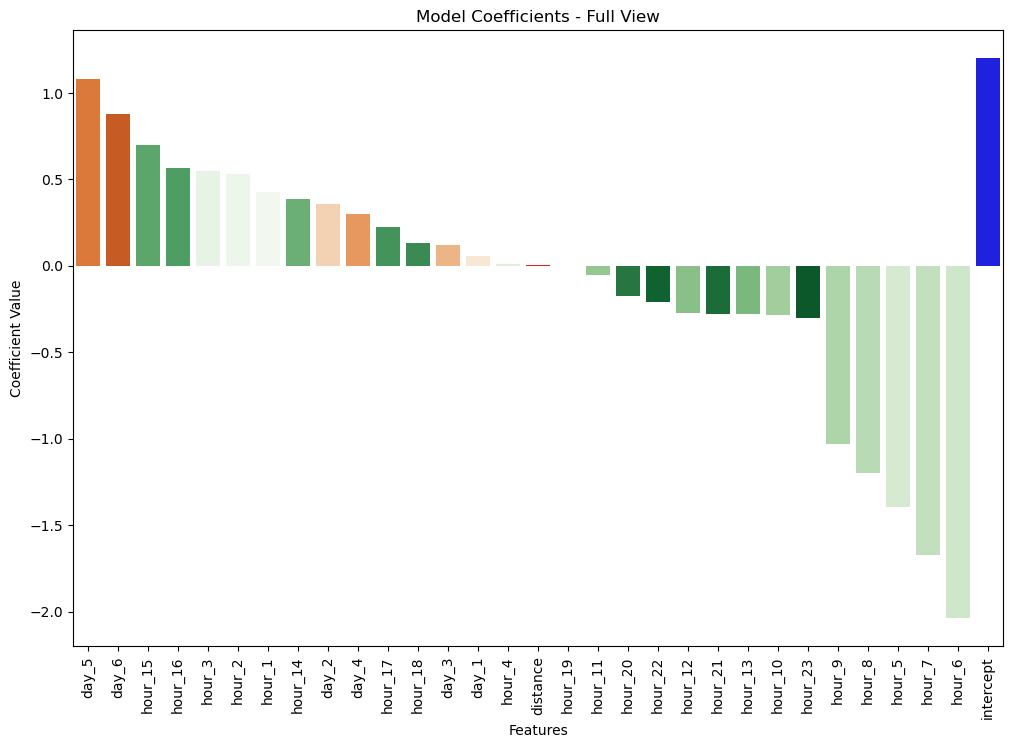

In [34]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('red')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

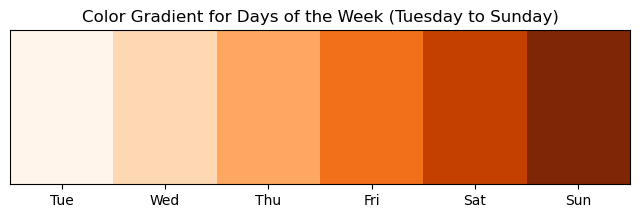

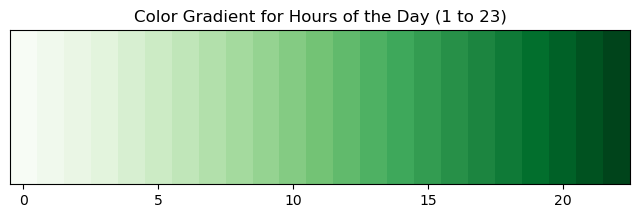

In [35]:
# Plotting a legend for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Oranges')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()

## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()

In [36]:
# Estimating 15km travel times with different hours of the day and days of the week with model1_day_hour
TT_15km_model1_day_hour = {}
for day in range(7):
    for hour in range(24):
        # Creating a dataframe with the distance, day and hour
        data = {'distance': [15000]}
        for d in range(1, 7):
            data[f'day_{d}'] = [1 if d == day else 0]
        for h in range(1, 24):
            data[f'hour_{h}'] = [1 if h == hour else 0]
        X_temp = pd.DataFrame(data)
        # Predicting the travel time
        TT_15km_model1_day_hour[(day, hour)] = model1_day_hour.predict(X_temp)[0]

# Displaying the estimated travel times for a 15km trip in a dataframe
df_TT_15km_model1_day_hour = pd.DataFrame.from_dict(TT_15km_model1_day_hour, orient='index', columns=['Estimated Travel Time (minutes)'])
df_TT_15km_model1_day_hour.index = pd.MultiIndex.from_tuples(df_TT_15km_model1_day_hour.index, names=['Day of the Week', 'Hour of the Day'])
df_TT_15km_model1_day_hour = df_TT_15km_model1_day_hour.sort_index()
df_TT_15km_model1_day_hour.sample(10)

Estimated Travel Time (minutes)
Day of the Week Hour of the Day                                 
2               14                                     88.947512
                7                                      86.890903
1               18                                     88.394153
6               0                                      89.084717
                23                                     88.780593
4               4                                      88.510638
2               2                                      89.093627
5               2                                      89.820002
4               18                                     88.635661
0               20                                     88.031890

In [37]:
from functions.estimator import MLR_model_estimator

# Example
test_distance = 15000  # in meters
test_travel_time = None  # unknown, to be predicted
test_datetime_1h = '2020-01-07 08:15:00'  # example datetime
test_day = 1  # Tuesday
test_month = 1  # January

sample_list = [test_distance, test_travel_time, test_datetime_1h, test_day, test_month]
pred = MLR_model_estimator(
    model=model1_day_hour,
    features=sample_list,
    feature_names=['distance','travel_time','datetime_1h','day','month'],
    model_feature_names=X.columns,   # X is the training DataFrame's columns used to fit the model
    show_steps=True
)
print(f"The predicted travel time for a {test_distance/1000} km trip is: {round(pred)} minutes")

[STEP] Starting estimation
[STEP] Extracted base features: {'distance': 15000, 'day': 1, 'datetime_1h': '2020-01-07 08:15:00', 'month': 1}
[STEP] distance = 15000.0
[STEP] Using provided day = 1
[STEP] Derived hour from datetime_1h = 8
[STEP] Using provided month = 1
[STEP] Using provided model_feature_names
[INFO] model will expect 30 features: ['distance', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
[STEP] Built input vector (first 10 values shown): [1.5e+04 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]
[STEP] Model intercept = 1.200917521879175
[STEP] Model has 30 coefficients; input vector length = 30
[RESULT] Predicted travel time = 87.06322969888878
The predicted travel time for a 15.0 km trip is: 87 mi

#### c/ Model 2 - Adding the temperature, the rain, and the wind

In [38]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2 = df_meteo[['distance', 'travel_time', 'datetime_1h', 'day', 'temp_category', 'rain_category', 'wind_category']].copy()
df_model2['hour'] = df_model2['datetime_1h'].dt.hour
# Filtering out the rows with 'unknown' categories
df_model2 = df_model2[
    (df_model2['temp_category'] != 'unknown') &
    (df_model2['wind_category'] != 'unknown')
].copy()
# Converting day and hour to integer type
df_model2['day'] = df_model2['day'].astype(int)
df_model2['hour'] = df_model2['hour'].astype(int)
df_model2.sample(5)

,distance,travel_time,datetime_1h,day,temp_category,rain_category,wind_category,hour
1090158,954.088206,6.0,2019-05-20 18:00:00+02:00,0,warm,light,light,18
551422,1746.841945,10.0,2019-04-25 13:00:00+02:00,3,warm,heavy,windy,13
1247001,782.082107,5.0,2019-05-26 20:00:00+02:00,6,warm,none,light,20
1171258,3309.535972,32.0,2019-05-23 18:00:00+02:00,3,warm,none,calm,18
1355181,2443.208196,17.0,2019-05-31 15:00:00+02:00,4,warm,none,calm,15


In [39]:
df_model2_dummies_hours_days = pd.get_dummies(df_model2, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model2_dummies = pd.get_dummies(df_model2_dummies_hours_days, columns=['temp_category', 'rain_category', 'wind_category'], drop_first=True, dtype="int")
df_model2_dummies.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,...,hour_21,hour_22,hour_23,temp_category_very_warm,temp_category_warm,rain_category_light,rain_category_moderate,rain_category_none,wind_category_light,wind_category_windy
1629990,2252.641897,19.0,2019-06-15 02:00:00+02:00,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1630827,2116.863635,12.0,2019-06-15 07:00:00+02:00,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
213354,1163.903739,6.0,2019-04-09 19:00:00+02:00,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
734691,804.324105,5.0,2019-05-03 17:00:00+02:00,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1009899,2118.351716,11.0,2019-05-16 18:00:00+02:00,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [40]:
df_model2_dummies.columns

Index(['distance', 'travel_time', 'datetime_1h', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'temp_category_very_warm', 'temp_category_warm', 'rain_category_light',
       'rain_category_moderate', 'rain_category_none', 'wind_category_light',
       'wind_category_windy'],
      dtype='object')

,Coefficient
day_5,1.099857
day_6,0.990092
hour_15,0.684543
rain_category_none,0.582253
hour_3,0.567951
hour_16,0.543363
hour_2,0.535103
day_2,0.473957
temp_category_very_warm,0.444560
hour_1,0.425889


R²      0.666520
MSE    18.359107
MAE     2.796976
dtype: float64

C:\Users\Alix\AppData\Local\Temp\ipykernel_22472\2093839321.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)


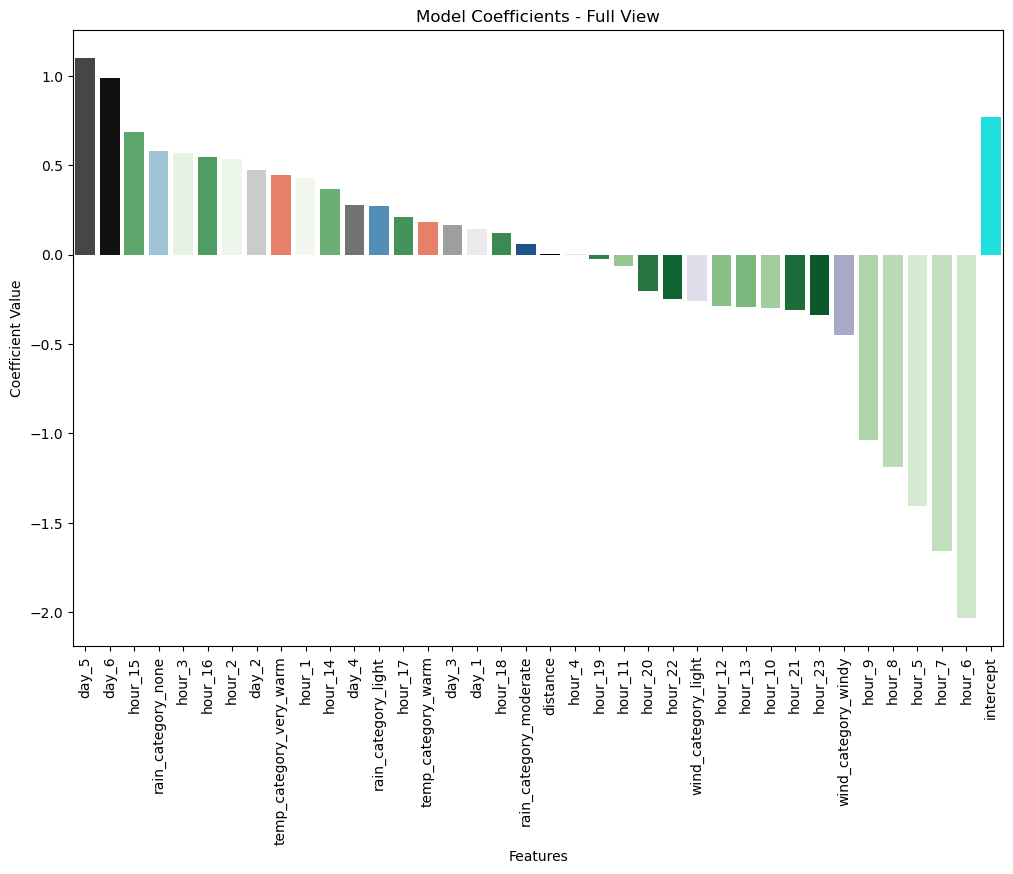

In [41]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2, X)
display(df_model2_coeffs)

## Displaying the model 1's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients with separate colors for the different types of features
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model2_coeffs.index:
    # Intercept is in cyan and is an interger (in minutes)
    if idx == 'intercept':
        colors.append('cyan')
    # Distance is in black and is an integer (in min/m)
    elif idx == 'distance':
        colors.append('black')
    # The days are a gradient from grey to black and are to be converted in integers based on the last digit
    elif idx.startswith('day_'):
        colors.append(plt.cm.Greys(int(idx.split('_')[1]) * 40))
    # The hours are a gradient of green and are to be converted in integers based on the last digit
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    # The temperature is a gradient of red and is composed of categories (strings)
    elif idx.startswith('temp_category_'):
        colors.append(plt.cm.Reds((['cold', 'cool', 'warm', 'very_warm'].index(idx.split('_')[-1])) * 60))
    # The rain is a gradient of deep blue and is composed of categories (strings)
    elif idx.startswith('rain_category_'):
        colors.append(plt.cm.Blues((['none', 'light', 'moderate', 'heavy'].index(idx.split('_')[-1])) * 60 + 100))
    # The wind is a gradient of purple and is composed of categories (strings)
    elif idx.startswith('wind_category_'):
        colors.append(plt.cm.Purples((['calm', 'light', 'windy', 'stormy'].index(idx.split('_')[-1])) * 60))
    else:
        colors.append('gray')
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

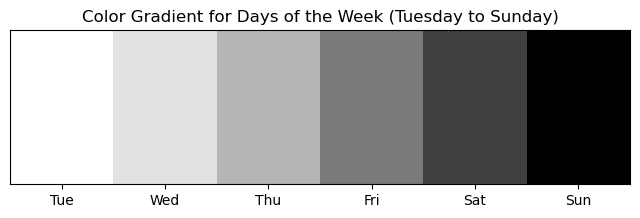

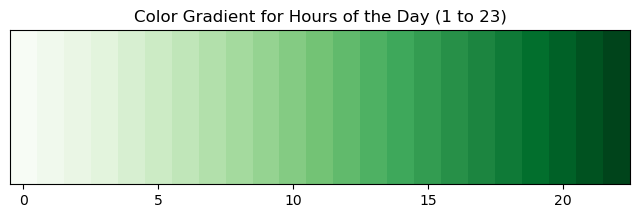

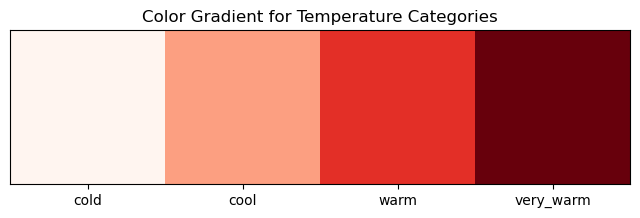

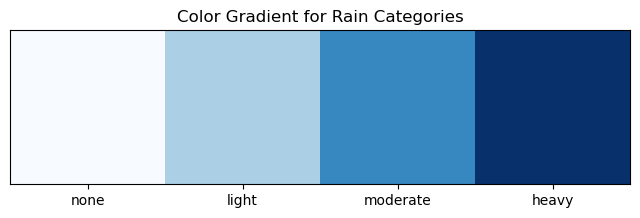

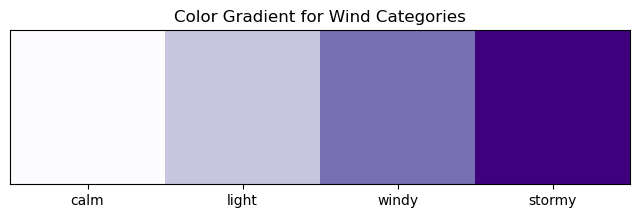

In [42]:
# Plotting the gradients legends for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Greys')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for temperature categories
plt.figure(figsize=(8, 2))
categories_temp = ["cold", "cool", "warm", "very_warm"]
gradient_temp = np.linspace(0, 1, len(categories_temp)).reshape(1, -1)
plt.imshow(gradient_temp, aspect='auto', cmap='Reds')
plt.title('Color Gradient for Temperature Categories')
# Changing the legend to show the temperature categories
plt.xticks(ticks=np.arange(len(categories_temp)), labels=categories_temp)
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for rain categories
plt.figure(figsize=(8, 2))
categories_RR = ["none", "light", "moderate", "heavy"]
gradient_rain = np.linspace(0, 1, len(categories_RR)).reshape(1, -1)
plt.imshow(gradient_rain, aspect='auto', cmap='Blues')
plt.title('Color Gradient for Rain Categories')
# Changing the legend to show the rain categories
plt.xticks(ticks=np.arange(len(categories_RR)), labels=categories_RR)
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for wind categories
plt.figure(figsize=(8, 2))
categories_wind = ["calm", "light", "windy", "stormy"]
gradient_wind = np.linspace(0, 1, len(categories_wind)).reshape(1, -1)
plt.imshow(gradient_wind, aspect='auto', cmap='Purples')
plt.title('Color Gradient for Wind Categories')
# Changing the legend to show the wind categories
plt.xticks(ticks=np.arange(len(categories_wind)), labels=categories_wind)
plt.yticks([])
plt.show()

d/ Model 3 - Adding the elevation

The idea is to evaluate the impact of the elevation on the OD travel time.

To be able to produce the elevation data, we split the area in clusters. 

Then we can associate each travel to a cluster of depart and a cluster of arrrival.

First Step: Eliminate exit and return stations outside of clusters

In [ ]:
# Filter each travel where cluster_exit_station == None or cluster_return_station == None

df_clusters = df_clusters[
    (df_clusters['cluster_exit_station'].notna()) & 
    (df_clusters['cluster_return_station'].notna())
].copy()   

KeyError: 'cluster_exit_station'

Now, we only have travels between 2 clusters.

Second Step: Create the matrix with the travel time, the distance, the positive elevation and the negative elevation between all clusters (based on their centroids)

Source: Google Maps

Note: To add some clusters in the matrix, add 'Cluster Name', 'Latitude', 'Longitude', from Clusters Part and with Google Maps, complete the following dataset : Distance, Time, D+, D- for each way (Start-End).

In [ ]:
import pandas as pd
import numpy as np

# 1. Raw Data Entry (Easily extensible)

# Each dictionary represents a unique trip: START -> END

raw_data = [
    # --- START : La Doua ---
    {"start": "La Doua", "end": "La Doua",    "dist": 0,    "time": 0,  "d+": 0,  "d-": 0},
    {"start": "La Doua", "end": "Tête d'Or",  "dist": 1.8,  "time": 7,  "d+": 2,  "d-": 2},
    {"start": "La Doua", "end": "Part Dieu",  "dist": 3.7,  "time": 14, "d+": 2,  "d-": 8},
    {"start": "La Doua", "end": "Old Town",   "dist": 4.9, "time": 19, "d+": 8,  "d-": 9},
    {"start": "La Doua", "end": "Confluence", "dist": 8.1,  "time": 26, "d+": 8,  "d-": 12},

    # --- START : Tête d'Or ---
    {"start": "Tête d'Or", "end": "La Doua",    "dist": 1.9, "time": 7,  "d+": 3,  "d-": 1},
    {"start": "Tête d'Or", "end": "Tête d'Or",  "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Tête d'Or", "end": "Part Dieu",  "dist": 2.4, "time": 10, "d+": 3,  "d-": 8},
    {"start": "Tête d'Or", "end": "Old Town",   "dist": 3.1, "time": 12, "d+": 8,  "d-": 8},
    {"start": "Tête d'Or", "end": "Confluence", "dist": 6.2, "time": 20, "d+": 7,  "d-": 10},

    # --- START : Part Dieu ---
    {"start": "Part Dieu", "end": "La Doua",    "dist": 4.2, "time": 17, "d+": 6,  "d-": 2},
    {"start": "Part Dieu", "end": "Tête d'Or",  "dist": 2.4, "time": 10, "d+": 5,  "d-": 2},
    {"start": "Part Dieu", "end": "Part Dieu",  "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Part Dieu", "end": "Old Town",   "dist": 2.3, "time": 10, "d+": 6,  "d-": 3},
    {"start": "Part Dieu", "end": "Confluence", "dist": 4.4, "time": 16, "d+": 8,  "d-": 7},

    # --- START : Old Town ---
    {"start": "Old Town", "end": "La Doua",    "dist": 4.9, "time": 19, "d+": 13, "d-": 12},
    {"start": "Old Town", "end": "Tête d'Or",  "dist": 3.0, "time": 12, "d+": 10, "d-": 11},
    {"start": "Old Town", "end": "Part Dieu",  "dist": 2.3, "time": 14, "d+": 3,  "d-": 6},
    {"start": "Old Town", "end": "Old Town",   "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Old Town", "end": "Confluence", "dist": 5.3, "time": 18, "d+": 10, "d-": 13},

    # --- START : Confluence ---
    {"start": "Confluence", "end": "La Doua",    "dist": 8.1, "time": 26, "d+": 13, "d-": 9},
    {"start": "Confluence", "end": "Tête d'Or",  "dist": 6.2, "time": 19, "d+": 11, "d-": 8},
    {"start": "Confluence", "end": "Part Dieu",  "dist": 4.8, "time": 19, "d+": 7,  "d-": 7},
    {"start": "Confluence", "end": "Old Town",   "dist": 4.6, "time": 14, "d+": 10, "d-": 7},
    {"start": "Confluence", "end": "Confluence", "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
]

# 2. Initial DataFrame creation
df_raw = pd.DataFrame(raw_data)

# 3. Pivot to structure as a matrix
df_matrix = df_raw.pivot(index="end", columns="start", values=["dist", "time", "d+", "d-"])

# 4. Aesthetic reorganization of columns (MultiIndex)
df_matrix = df_matrix.swaplevel(0, 1, axis=1)
df_matrix = df_matrix.sort_index(axis=1)

# Rename metrics
rename_map = {
    "dist": "Dist (km)",
    "time": "Time (min)",
    "d+": "Elev+ (m)",
    "d-": "Elev- (m)"
}
df_matrix = df_matrix.rename(columns=rename_map, level=1)

# Reorder Rows and Columns
desired_order = ["La Doua", "Tête d'Or", "Part Dieu", "Old Town", "Confluence"]
df_matrix = df_matrix.reindex(desired_order, axis=0)
df_matrix = df_matrix.reindex(desired_order, axis=1, level=0)

# 5. Display with Grid Lines (Custom Formatting)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Convert to string first to handle alignment
output_str = df_matrix.to_string()
lines = output_str.split('\n')

# Calculate separator length based on the first line width
separator = "-" * len(lines[0])

print("\n--- Matrix ---")

# The first few lines are headers (MultiIndex has 2 levels + 1 index name line = 3 lines usually)
header_rows = 3 
for i, line in enumerate(lines):
    print(line)
    # Print separator after headers are done, and then after each data row
    if i == header_rows - 1:
        print(separator) # Separator between Header and Data
    elif i >= header_rows:
        print(separator) # Separator between Data rows


--- Detailed Matrix with Separators ---
start        La Doua                                Tête d'Or                                Part Dieu                                 Old Town                                Confluence                               
           Elev+ (m) Elev- (m) Dist (km) Time (min) Elev+ (m) Elev- (m) Dist (km) Time (min) Elev+ (m) Elev- (m) Dist (km) Time (min) Elev+ (m) Elev- (m) Dist (km) Time (min)  Elev+ (m) Elev- (m) Dist (km) Time (min)
end                                                                                                                                                                                                                     
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
La Doua          0.0       0.0       0.0        0.0       3.0       1.0       1.9        7.

In [ ]:
import pandas as pd

# 1. Create Reference DataFrame (Lookup Table)

df_google_ref = pd.DataFrame(raw_data)

# Rename columns to match desired final table format

df_google_ref = df_google_ref.rename(columns={
    "dist": "GM_distance",
    "time": "GM_TT",
    "d+": "GM_d+",
    "d-": "GM_d-"
})

# 2. Keep all rows from df_clusters and add Google info where there is a match

df_clusters = df_clusters.merge(
    df_google_ref, 
    how='left',  # 'left' is crucial: if no match is found, we don't lose the row, we get NaNs
    left_on=['cluster_exit', 'cluster_return'], # Columns in df_clusters
    right_on=['start', 'end']                   # Columns in df_google_ref
)

# 3. Cleanup

# The merge added 'start' and 'end' columns which duplicate 'cluster_exit' and 'cluster_return'. We can drop them.

df_clusters = df_clusters.drop(columns=['start', 'end'])

# 4. Testing the merge

# Display key columns to verify

cols_to_show = ['trip_id', 'cluster_exit', 'cluster_return', 'GM_distance', 'GM_TT', 'GM_d+', 'GM_d-']
print(df_clusters[cols_to_show])